# TP : Word Embeddings for Classification

## Authors: BENEDETTI DA ROSA Giovanni and DA SILVA BUENO Tarcisio

## Objectives:

Explore the various way to represent textual data by applying them to a relatively small French classification dataset based on professionnal certification titles - **RNCP** - and evaluate how they perform on the classification task. 
1. Using what we have previously seen, pre-process the data: clean it, obtain an appropriate vocabulary.
2. Obtain representations: any that will allow us to obtain a vector representation of each document is appropriate.
    - Symbolic: **BoW, TF-IDF**
    - Dense document representations: via **Topic Modeling: LSA, LDA**
    - Dense word representations: **SVD-reduced PPMI, Word2vec, GloVe**
        - For these, you will need to implement a **function aggregating word representations into document representations**
3. Perform classification: we can make things simple and only use a **logistic regression**

## Necessary dependancies

We will need the following packages:
- The Machine Learning API Scikit-learn : http://scikit-learn.org/stable/install.html
- The Natural Language Toolkit : http://www.nltk.org/install.html
- Gensim: https://radimrehurek.com/gensim/

These are available with Anaconda: https://anaconda.org/anaconda/nltk and https://anaconda.org/anaconda/scikit-learn

In [1]:
import os.path as op
import re 
import numpy as np
import matplotlib.pyplot as plt
import pprint
import pandas as pd
import gzip
pp = pprint.PrettyPrinter(indent=3)

## Loading data

Let's load the data: take a first look.

In [2]:
with open("rncp.csv", encoding='utf-8') as f:
    rncp = pd.read_csv(f, na_filter=False)

rncp.head()

,Categorie,text_certifications
0,1,Responsable de chantiers de bûcheronnage manue...
1,1,Responsable de chantiers de bûcheronnage manue...
2,1,Travaux forestiers
3,1,Forêt
4,1,Forêt


In [3]:
print(rncp.columns.values)
texts = rncp.loc[:,'text_certifications'].astype('str').tolist()
labels = rncp.loc[:,'Categorie'].astype('str').tolist()

['Categorie' 'text_certifications']


You can see that the first column is the category, the second the title of the certification. Let's get the category names for clarity: 

In [4]:
Categories = ["1-environnement",
              "2-defense",
              "3-patrimoine",
              "4-economie",
              "5-recherche",
              "6-nautisme",
              "7-aeronautique",
              "8-securite",
              "9-multimedia",
              "10-humanitaire",
              "11-nucleaire",
              "12-enfance",
              "13-saisonnier",
              "14-assistance",
              "15-sport",
              "16-ingenierie"]

In [5]:
pp.pprint(texts[:10])

[  'Responsable de chantiers de bûcheronnage manuel et de débardage',
   'Responsable de chantiers de bûcheronnage manuel et de sylviculture',
   'Travaux forestiers',
   'Forêt',
   'Forêt',
   'Responsable de chantiers forestiers',
   'Diagnostic et taille des arbres',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'abattage-façonnage',
   'option Chef d’entreprise ou OHQ en travaux forestiers, spécialité '
   'débardage',
   'Gestion et conduite de chantiers forestiers']


Use the function ```train_test_split```from ```sklearn``` function to set aside test data that you will use during the lab. Make it one fifth of the data you have currently.

<div class='alert alert-block alert-info'>
            Code:</div>

In [6]:
# This number of documents may be high for some computers: we can select a fraction of them (here, one in k)
# Use an even number to keep the same number of positive and negative reviews
k = 10
texts_reduced = texts[0::k]
labels_reduced = labels[0::k]

In [7]:
# split the data in training and test sets
from sklearn.model_selection import train_test_split

train_texts, test_texts, train_labels, test_labels = train_test_split(texts_reduced, labels_reduced, test_size=0.2, random_state=42)

## 1 - Document Preprocessing

You should use a pre-processing function you can apply to the raw text before any other processing (*i.e*, tokenization and obtaining representations). Some pre-processing can also be tied with the tokenization (*i.e*, removing stop words). Complete the following function, using the appropriate ```nltk``` tools. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [8]:
!pip install nltk


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [9]:
# Imports
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
import string

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

<div class='alert alert-block alert-info'>
            Code:</div>

In [10]:
def preprocess_text(text):
    # Convert text to lower case
    text = text.lower()

    # Remove everything except alphanumeric characters and diacritics
    text = re.sub(r'[^\w\sÀ-ÿ]', ' ', text)

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stop words
    stop_words = set(stopwords.words('french'))
    tokens = [token for token in tokens if token not in stop_words]

    stemmer = SnowballStemmer('french')
    tokens = [stemmer.stem(token) for token in tokens]
    
    return tokens

In [11]:
texts_processed = [preprocess_text(t) for t in train_texts]
test_texts_processed = [preprocess_text(t) for t in test_texts]

Now that the data is cleaned, the first step we will follow is to pick a common vocabulary that we will use for every representations we obtain in this lab. **Use the code of the previous lab to create a vocabulary.**

<div class='alert alert-block alert-info'>
            Code:</div>

In [12]:
def count_words(texts):
    """Vectorize text : return count of each word in the text snippets

    Parameters
    ----------
    texts : list of str
        The texts
    Returns
    -------
    vocabulary : dict
        A dictionary that points to an index in counts for each word.
    counts : ndarray, shape (n_samples, n_features)
        The counts of each word in each text.
    """
    words = []
    for text in texts:
        text = preprocess_text(text)
        words += text
    vocabularySet = set(words)
    vocabulary = dict(zip(list(vocabularySet),np.arange(len(vocabularySet))))
    
    counts = np.zeros((len(texts), len(vocabularySet) ), dtype=int)
    for k, text in enumerate(texts):
        for word in preprocess_text(text):
            counts[k,vocabulary[word]] += 1
    
    
    word_freq = {}
    for k, text in enumerate(texts):
        for word in preprocess_text(text):
            counts[k,vocabulary[word]] += 1
            if word in word_freq:
                word_freq[word] += 1
            else:
                word_freq[word] = 1
    
    return vocabulary, counts, word_freq

In [13]:

vocabulary, counts, word_counts = count_words(train_texts)
print(len(vocabulary))
print(f'Length of vocabulary: {len(vocabulary)}')
print(f'Vocabulary: {list(vocabulary.keys())[:10]}...')

2522
Length of vocabulary: 2522
Vocabulary: ['rhôn', 'menuiser', 'pcmhp', 'asr', 'microbien', 'ambianc', 'lasall', 'pens', 'numes', 'art']...


<div class='alert alert-block alert-warning'>
            Question:</div>

What do you think is the **appropriate vocabulary size here** ? Would any further pre-processing make sense ? Motivate your answer.

<div class='alert alert-block alert-warning'>
            Answer:</div>

The vocabulary size should be able represent most of the corpus, therefore we can choose a vocabulary size that is able to capture a percentage K of the corpus. We think that a value of K=95% would suffice. As we can see below, by using this value of K, the vocabulary size reduced considerably which makes sense based on the Zipf's law. 

In [14]:
K = 0.95

# Sort word_counts by frequency
sorted_word_counts = sorted(word_counts.items(), key=lambda x: x[1], reverse=True)

total_word_count = sum(word_counts.values())

# Compute the number of words that account for 95% of the total word count
n_words = 0
n_most_common_words = 0
for i, (word, count) in enumerate(sorted_word_counts):
    n_words += count
    n_most_common_words += 1
    if n_words / total_word_count >= K:
        break
    
    
print(f'The {n_most_common_words} most common words account for {K*100}% of the total word count.')
print(f'Original size of the vocabulary: {len(vocabulary)}')

The 925 most common words account for 95.0% of the total word count.
Original size of the vocabulary: 2522


In [15]:
# Keep only the n_most_common_words most common words
most_common_words = dict(sorted_word_counts[:n_most_common_words])
vocabulary = {word: i for i, (word, _) in enumerate(most_common_words.items())}

print(f'Length of the vocabulary after reduction: {len(vocabulary)}')
print(f'Vocabulary: {list(vocabulary.keys())[:50]}...')

Length of the vocabulary after reduction: 925
Vocabulary: ['spécial', 'mention', 'scienc', 'sant', 'technolog', 'ingénieur', 'diplôm', 'gestion', 'manag', 'national', 'domain', 'droit', 'informat', 'mast', 'system', 'professionnel', 'industriel', 'gen', 'social', 'environ', 'supérieur', 'art', 'langu', 'méti', 'option', 'univers', 'ecol', 'appliqu', 'développ', 'humain', 'commun', 'ingénier', 'final', 'projet', 'fich', 'économ', 'econom', 'recherch', 'product', 'lettr', 'biolog', 'institut', 'inform', 'polytechn', 'respons', 'écol', 'international', 'réseau', 'sécur', 'mécan']...


## 2 - Symbolic text representations

We can use the ```CountVectorizer``` class from scikit-learn to obtain the first set of representations:
- Use the appropriate argument to get your own vocabulary
- Fit the vectorizer on your training data, transform your test data
- Create a ```LogisticRegression``` model and train it with these representations. Display the confusion matrix using functions from ```sklearn.metrics``` 

Then, re-execute the same pipeline with the ```TfidfVectorizer```.

<div class='alert alert-block alert-info'>
            Code:</div>

In [16]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report


# Function to plot confusion matrix
def plot_confusion_matrix(cm, classes, title):
    # Convert to integers, sort, and then convert back to strings
    sorted_classes = sorted(classes, key=int)
    sorted_indices = [list(classes).index(cls) for cls in sorted_classes]

    # Reorder the confusion matrix
    cm_sorted = cm[sorted_indices, :][:, sorted_indices]

    conf_mat_disp = ConfusionMatrixDisplay(cm_sorted, display_labels=sorted_classes)
    fig, ax = plt.subplots(figsize=(10, 10))
    conf_mat_disp.plot(ax=ax)
    plt.title(title)
    plt.show()
    

In [17]:
# Join the words in each document into a single string
texts_processed_joined = [' '.join(doc) for doc in texts_processed]
test_texts_processed_joined = [' '.join(doc) for doc in test_texts_processed]

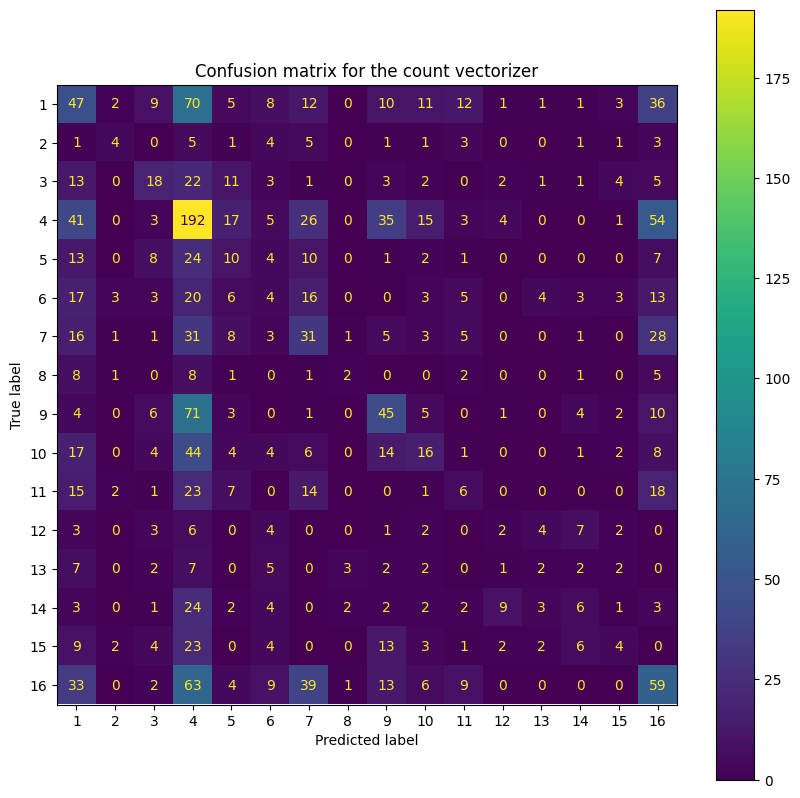

              precision    recall  f1-score   support

           1       0.19      0.21      0.20       228
          10       0.22      0.13      0.16       121
          11       0.12      0.07      0.09        87
          12       0.09      0.06      0.07        34
          13       0.12      0.06      0.08        35
          14       0.18      0.09      0.12        64
          15       0.16      0.05      0.08        73
          16       0.24      0.25      0.24       238
           2       0.27      0.13      0.18        30
           3       0.28      0.21      0.24        86
           4       0.30      0.48      0.37       396
           5       0.13      0.12      0.13        80
           6       0.07      0.04      0.05       100
           7       0.19      0.23      0.21       134
           8       0.22      0.07      0.11        29
           9       0.31      0.30      0.30       152

    accuracy                           0.24      1887
   macro avg       0.19   

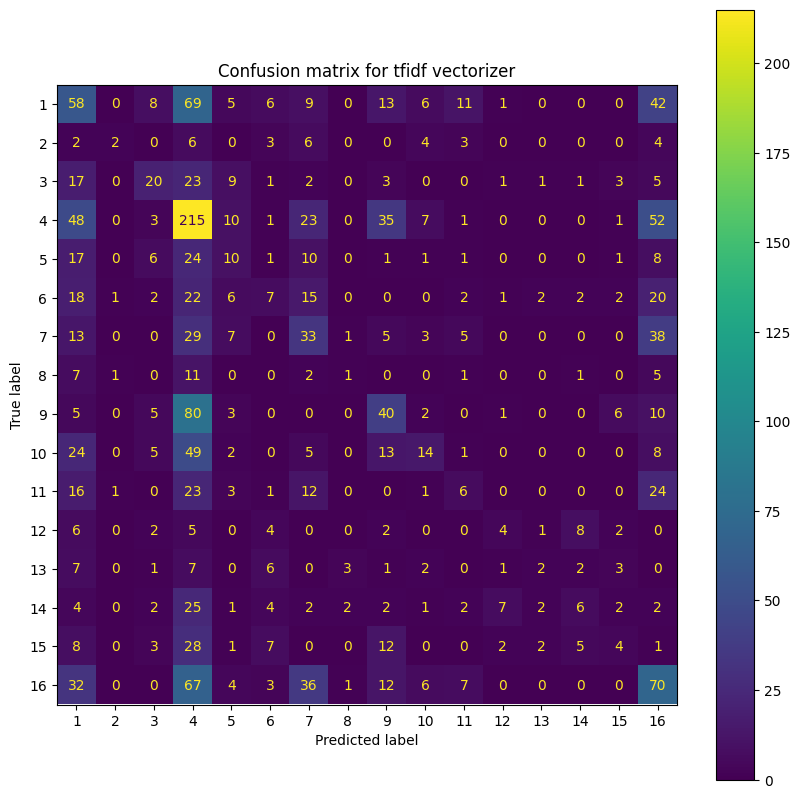

              precision    recall  f1-score   support

           1       0.21      0.25      0.23       228
          10       0.30      0.12      0.17       121
          11       0.15      0.07      0.09        87
          12       0.22      0.12      0.15        34
          13       0.20      0.06      0.09        35
          14       0.24      0.09      0.13        64
          15       0.17      0.05      0.08        73
          16       0.24      0.29      0.27       238
           2       0.40      0.07      0.11        30
           3       0.35      0.23      0.28        86
           4       0.31      0.54      0.40       396
           5       0.16      0.12      0.14        80
           6       0.16      0.07      0.10       100
           7       0.21      0.25      0.23       134
           8       0.12      0.03      0.05        29
           9       0.29      0.26      0.27       152

    accuracy                           0.26      1887
   macro avg       0.23   

In [18]:
# CountVectorizer
pipeline = Pipeline([
    ('vectorizer', CountVectorizer(vocabulary=vocabulary)),
    ('classifier', LogisticRegression(max_iter=10000))
])

pipeline.fit(texts_processed_joined, train_labels)
predictions = pipeline.predict(test_texts_processed_joined)

cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, pipeline.named_steps['classifier'].classes_, "Confusion matrix for the count vectorizer")
print(classification_report(test_labels, predictions))

# TfidfVectorizer
pipeline = Pipeline([
    ('vectorizer', TfidfVectorizer(vocabulary=vocabulary)),
    ('classifier', LogisticRegression(max_iter=10000))
])

pipeline.fit(texts_processed_joined, train_labels)
predictions = pipeline.predict(test_texts_processed_joined)
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, pipeline.named_steps['classifier'].classes_, "Confusion matrix for tfidf vectorizer")
print(classification_report(test_labels, predictions))

## 3 - Dense Representations from Topic Modeling

Now, the goal is to re-use the bag-of-words representations we obtained earlier - but reduce their dimension through a **topic model**. Note that this allows to obtain reduced **document representations**, which we can again use directly to perform classification.
- Do this with two models: ```TruncatedSVD``` and ```LatentDirichletAllocation```
- Pick $300$ as the dimensionality of the latent representation (*i.e*, the number of topics)

<div class='alert alert-block alert-info'>
            Code:</div>

In [19]:
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation

In [20]:
vectorizer =  CountVectorizer(vocabulary=vocabulary)
texts_vectorized = vectorizer.fit_transform(texts_processed_joined)
test_texts_vectorized = vectorizer.transform(test_texts_processed_joined)

In [21]:
# Number of topics
n_topics = 300

# TruncatedSVD
svd = TruncatedSVD(n_components=n_topics)
topic_svd = svd.fit_transform(texts_vectorized)
test_topic_svd = svd.transform(test_texts_vectorized)

# LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=n_topics, random_state=0)
topic_lda = lda.fit_transform(texts_vectorized)
test_topic_lda = lda.transform(test_texts_vectorized)

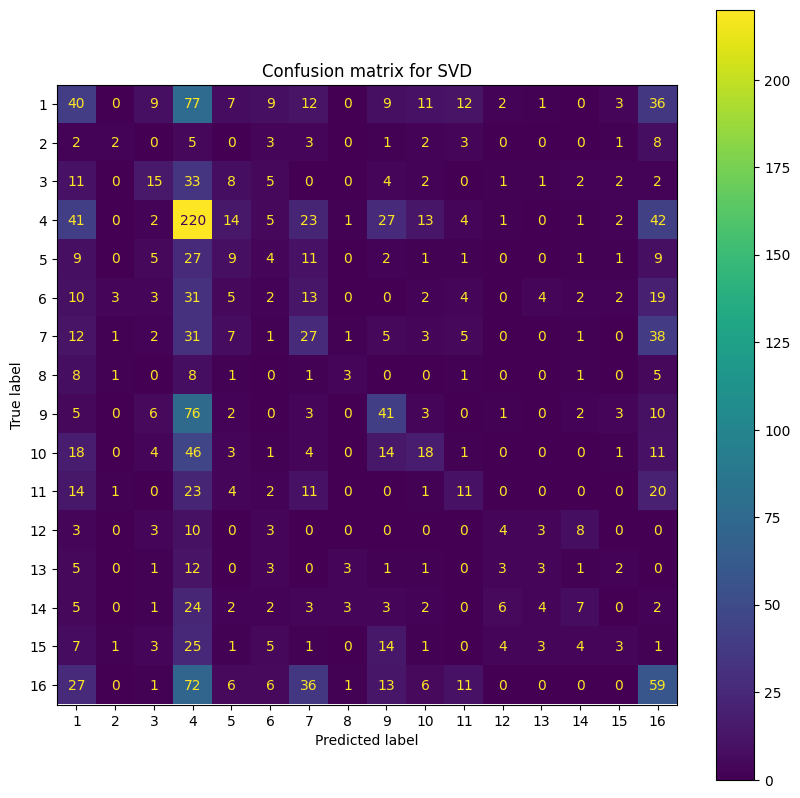

              precision    recall  f1-score   support

           1       0.18      0.18      0.18       228
          10       0.27      0.15      0.19       121
          11       0.21      0.13      0.16        87
          12       0.18      0.12      0.14        34
          13       0.16      0.09      0.11        35
          14       0.23      0.11      0.15        64
          15       0.15      0.04      0.06        73
          16       0.23      0.25      0.24       238
           2       0.22      0.07      0.10        30
           3       0.27      0.17      0.21        86
           4       0.31      0.56      0.39       396
           5       0.13      0.11      0.12        80
           6       0.04      0.02      0.03       100
           7       0.18      0.20      0.19       134
           8       0.25      0.10      0.15        29
           9       0.31      0.27      0.29       152

    accuracy                           0.25      1887
   macro avg       0.21   

In [38]:
model_svd = LogisticRegression(max_iter=10000)
model_svd.fit(topic_svd, train_labels)
predictions_svd = model_svd.predict(test_topic_svd) 
cm_svd = confusion_matrix(test_labels, predictions_svd)
plot_confusion_matrix(cm_svd, model_svd.classes_, "Confusion matrix for SVD")
print(classification_report(test_labels, predictions_svd))

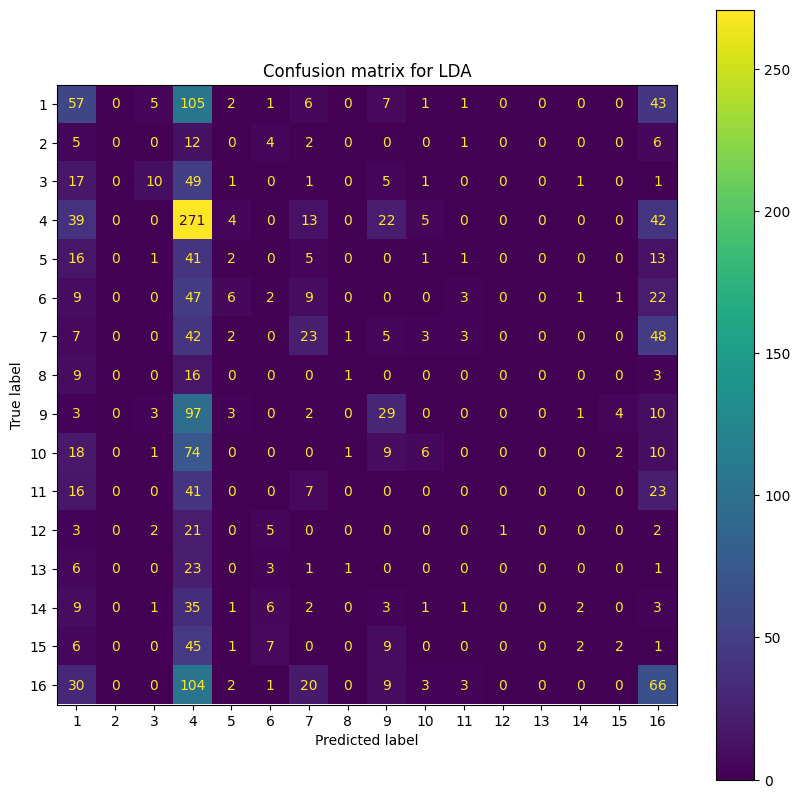

              precision    recall  f1-score   support

           1       0.23      0.25      0.24       228
          10       0.29      0.05      0.08       121
          11       0.00      0.00      0.00        87
          12       1.00      0.03      0.06        34
          13       0.00      0.00      0.00        35
          14       0.29      0.03      0.06        64
          15       0.22      0.03      0.05        73
          16       0.22      0.28      0.25       238
           2       0.00      0.00      0.00        30
           3       0.43      0.12      0.18        86
           4       0.26      0.68      0.38       396
           5       0.08      0.03      0.04        80
           6       0.07      0.02      0.03       100
           7       0.25      0.17      0.20       134
           8       0.25      0.03      0.06        29
           9       0.30      0.19      0.23       152

    accuracy                           0.25      1887
   macro avg       0.24   

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.p

In [23]:
model_lda = LogisticRegression(max_iter=10000)
model_lda.fit(topic_lda, train_labels)
predictions_lda = model_lda.predict(test_topic_lda)
cm_lda = confusion_matrix(test_labels, predictions_lda)
plot_confusion_matrix(cm_lda, model_lda.classes_, "Confusion matrix for LDA")
print(classification_report(test_labels, predictions_lda))

<div class='alert alert-block alert-warning'>
            Question:</div>
            
We picked $300$ as number of topics. What would be the procedure to follow if we wanted to choose this hyperparameter through the data ? 

<div class='alert alert-block alert-warning'>
            Answer:</div>
            
In order to choose this hyperparameter trough the data we could use a cross-validation and check a metric such as accuracy or f1-score to decide the best number of topics. 

## 4 - Dense Count-based Representations

The following function allows to obtain very large-dimensional vectors for **words**. We will now follow a different procedure:
- Step 1: Obtain the co-occurence matrix, based on the vocabulary, giving you a vector by word in the vocabulary.
- Step 2: Apply an SVD to obtain **word embeddings** of dimension $300$, for each word in the vocabulary.
- Step 3: Obtain document representations by aggregating embeddings associated to each word in the document.
- Step 4: Train a classifier on the (document representations, label) pairs. 

Some instructions:
- In step 1, use the ```co_occurence_matrix``` function, which you need to complete.
- In step 2, use ```TruncatedSVD```to obtain word representations of dimension $300$ from the output of the ```co_occurence_matrix``` function.
- In step 3, use the ```sentence_representations``` function, which you will need to complete.
- In step 4, put the pipeline together by obtaining document representations for both training and testing data. Careful: the word embeddings must come from the *training data co-occurence matrix* only.

Lastly, add a **Step 1b**: transform the co-occurence matrix into the PPMI matrix, and compare the results.

In [42]:
def co_occurence_matrix(corpus, vocabulary, window=0):
    """
    Params:
        corpus (list of list of strings): corpus of sentences
        vocabulary (dictionary): words to use in the matrix
        window (int): size of the context window; when 0, the context is the whole sentence
    Returns:
        matrix (array of size (len(vocabulary), len(vocabulary))): the co-oc matrix, using the same ordering as the vocabulary given in input    
    """ 
    l = len(vocabulary)
    M = np.zeros((l,l))
    for sent in corpus:
        # Obtain the indexes of the words in the sentence from the vocabulary 
        sent_idx = [vocabulary[word] if word in vocabulary else len(vocabulary)-1 for word in sent]
        # Avoid one-word sentences - can create issues in normalization:
        if len(sent_idx) == 1:
            sent_idx.append(len(vocabulary)-1) # This adds an Unknown word to the sentence
        # Go through the indexes and add 1 / dist(i,j) to M[i,j] if words of index i and j appear in the same window
        for i, idx in enumerate(sent_idx):
            # If we consider a limited context:
            if window > 0:
                # Create a list containing the indexes that are on the left of the current index 'idx_i'
                l_ctx_idx = sent_idx[max(0, i-window):i]                
            # If the context is the entire document:
            else:
                # The list containing the left context is easier to create
                l_ctx_idx = sent_idx[:i]
            # Go through the list and update M[i,j] and M[j,i]:        
            for j, ctx_idx in enumerate(l_ctx_idx):
                M[idx, ctx_idx] += 1 / abs(i-j)
                M[ctx_idx, idx] += 1 / abs(i-j)
    return M

def ppmi_matrix(co_occurrence_matrix):
    # Compute the sum of all elements in the co-occurrence matrix
    total_co_occurrences = np.sum(co_occurrence_matrix)

    # Compute the row sums and column sums of the co-occurrence matrix
    word_counts = np.sum(co_occurrence_matrix, axis=0)
    
    # Compute the probabilities of individual words and word co-occurrences
    word_probabilities = word_counts / total_co_occurrences
    co_occurrence_probabilities = co_occurrence_matrix / total_co_occurrences

    # Compute the PPMI matrix
    ppmi_matrix = np.maximum(0, np.log2(co_occurrence_probabilities / (word_probabilities[None, :] * word_probabilities[:, None])))

    return ppmi_matrix


<div class='alert alert-block alert-info'>
            Code:</div>

In [46]:
# Obtain the co-occurence matrix, transform it as needed, reduce its dimension

M = co_occurence_matrix(texts_processed, vocabulary, window=0)


In [47]:
# Truncate using truncated svd
svd = TruncatedSVD(n_components=300)
matrix_svd = svd.fit_transform(M)

<div class='alert alert-block alert-info'>
            Code:</div>

In [27]:
def sentence_representations(texts, vocabulary, embeddings, np_func=np.mean):
    """
    Represent the sentences as a combination of the vector of its words.
    Parameters
    ----------
    texts : a list of sentences   
    vocabulary : dict
        From words to indexes of vector.
    embeddings : Matrix containing word representations
    np_func : function (default: np.sum)
        A numpy matrix operation that can be applied columnwise, 
        like `np.mean`, `np.sum`, or `np.prod`. 
    Returns
    -------
    np.array, dimension `(len(texts), embeddings.shape[1])`            
    """
    representations = []
    for text in texts:
        # Indexes of words in the sentence obtained thanks to the vocabulary
        indexes = [vocabulary[word] for word in text if word in vocabulary and vocabulary[word] < len(embeddings)]
        # Embeddings of words in the sentence, aggregated thanks to the function
        sentrep = np_func(embeddings[indexes], axis=0) if indexes else np.zeros(embeddings.shape[1])
        representations.append(sentrep)
        
    representations = np.array(representations)
    return representations

<div class='alert alert-block alert-info'>
            Code:</div>

In [28]:
# Obtain document representations, apply the classifier

train_representations = sentence_representations(texts_processed, vocabulary, matrix_svd)
test_representations = sentence_representations(test_texts_processed, vocabulary, matrix_svd)

In [29]:
model = LogisticRegression(max_iter=10000)
model.fit(train_representations, train_labels)
predictions = model.predict(test_representations)

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\linear_model\_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


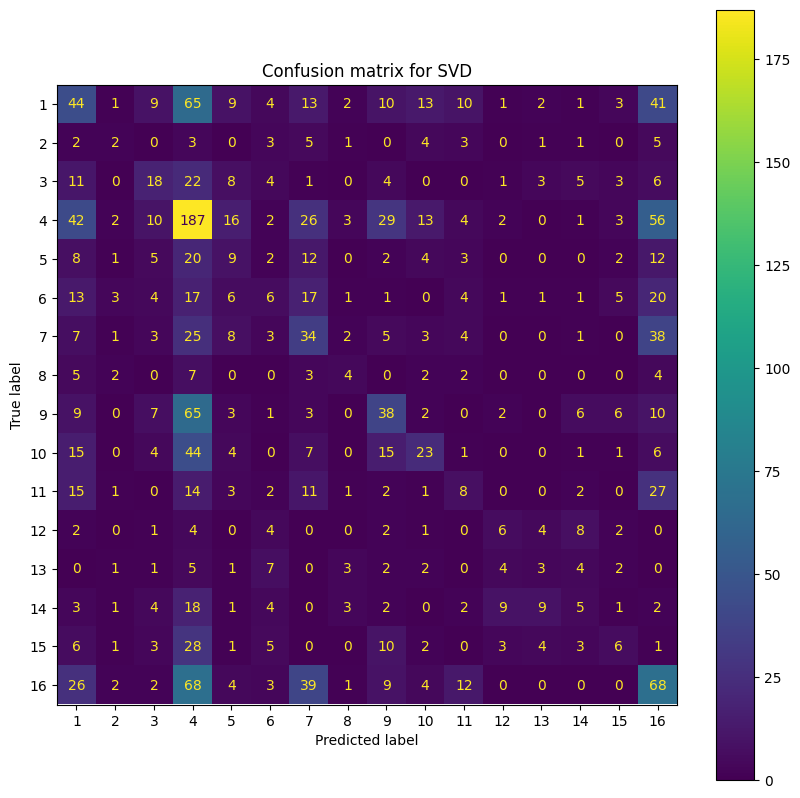

              precision    recall  f1-score   support

           1       0.21      0.19      0.20       228
          10       0.31      0.19      0.24       121
          11       0.15      0.09      0.11        87
          12       0.21      0.18      0.19        34
          13       0.11      0.09      0.10        35
          14       0.13      0.08      0.10        64
          15       0.18      0.08      0.11        73
          16       0.23      0.29      0.25       238
           2       0.11      0.07      0.08        30
           3       0.25      0.21      0.23        86
           4       0.32      0.47      0.38       396
           5       0.12      0.11      0.12        80
           6       0.12      0.06      0.08       100
           7       0.20      0.25      0.22       134
           8       0.19      0.14      0.16        29
           9       0.29      0.25      0.27       152

    accuracy                           0.24      1887
   macro avg       0.20   

In [30]:
cm = confusion_matrix(test_labels, predictions)

plot_confusion_matrix(cm, model.classes_, "Confusion matrix for SVD")
print(classification_report(test_labels, predictions))


## 5 - Dense Prediction-based Representations

We will now use word embeddings from ```Word2Vec```: which we will train ourselves

We will use the ```gensim``` library for its implementation of word2vec in python. Since we want to keep the same vocabulary as before: we'll first create the model, then re-use the vocabulary we generated above. 

In [31]:
!pip install gensim


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: C:\Users\Usuario\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [32]:
from gensim.models import Word2Vec

<div class='alert alert-block alert-info'>
            Code:</div>

In [33]:
model = Word2Vec(texts_processed_joined, vector_size=300, window=5, min_count=1, workers=4)
word_embeddings = model.wv.vectors

Then, we can re-use the ```sentence_representations```function like before to obtain document representations, and apply classification. 
<div class='alert alert-block alert-info'>
            Code:</div>

In [34]:
train_representations = sentence_representations(texts_processed, vocabulary, word_embeddings)
test_representations = sentence_representations(test_texts_processed, vocabulary, word_embeddings)

In [35]:
model = LogisticRegression(max_iter=10000)
model.fit(train_representations, train_labels)
predictions = model.predict(test_representations)

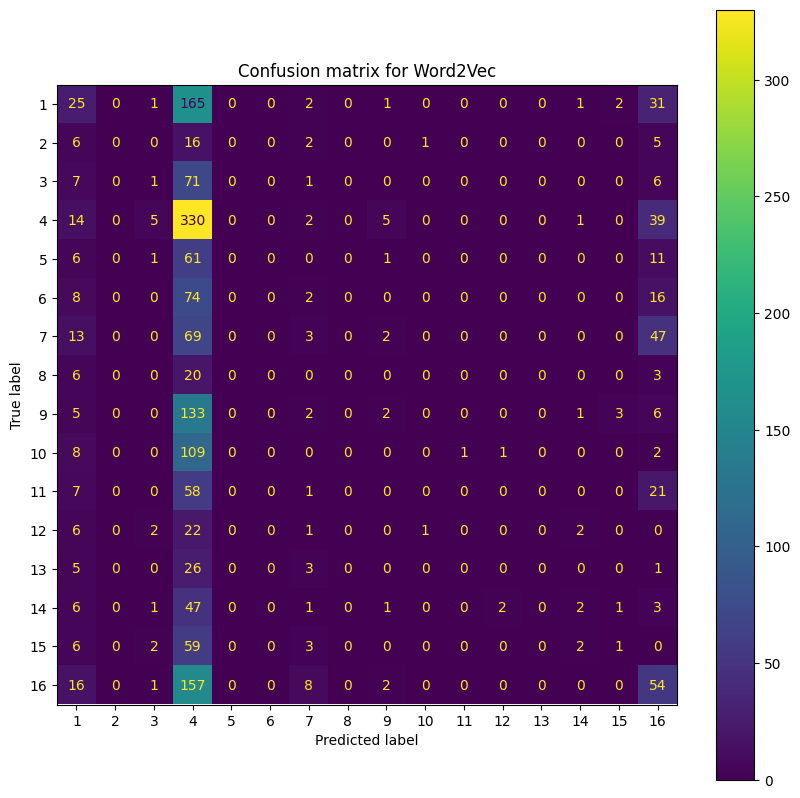

              precision    recall  f1-score   support

           1       0.17      0.11      0.13       228
          10       0.00      0.00      0.00       121
          11       0.00      0.00      0.00        87
          12       0.00      0.00      0.00        34
          13       0.00      0.00      0.00        35
          14       0.22      0.03      0.05        64
          15       0.14      0.01      0.03        73
          16       0.22      0.23      0.22       238
           2       0.00      0.00      0.00        30
           3       0.07      0.01      0.02        86
           4       0.23      0.83      0.36       396
           5       0.00      0.00      0.00        80
           6       0.00      0.00      0.00       100
           7       0.10      0.02      0.04       134
           8       0.00      0.00      0.00        29
           9       0.14      0.01      0.02       152

    accuracy                           0.22      1887
   macro avg       0.08   

C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Usuario\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\metrics\_classification.p

In [36]:
cm = confusion_matrix(test_labels, predictions)
plot_confusion_matrix(cm, model.classes_, "Confusion matrix for Word2Vec")
print(classification_report(test_labels, predictions))

<div class='alert alert-block alert-warning'>
            Question:</div>
            
Comment on the results. What is the big issue with the dataset that using embeddings did not solve ? 
**Given this type of data**, what would you propose if you needed solve this task (i.e, reach a reasonnable performance) in an industrial context ? 

<div class='alert alert-block alert-warning'>
            Answer:</div>

The main problem in this task is that clearly we have imbaleced classes. The classes with more samples, class 4, is more often well classified. In order to solve this issue we could oversample the classes with less samples or undersample the most frequents classes.

As reported in the paper Padurariu, Cristian, and Mihaela Elena Breaban. “Dealing with Data Imbalance in Text Classification.” Procedia Computer Science, vol. 159, 2019, pp. 736–745, https://doi.org/10.1016/j.procs.2019.09.229.(https://doi.org/10.1016/j.procs.2019.09.229), the undersamples techniques did not performed well in their experiments and oversample techniques such as Random oversampling and SMOTE have worked better.

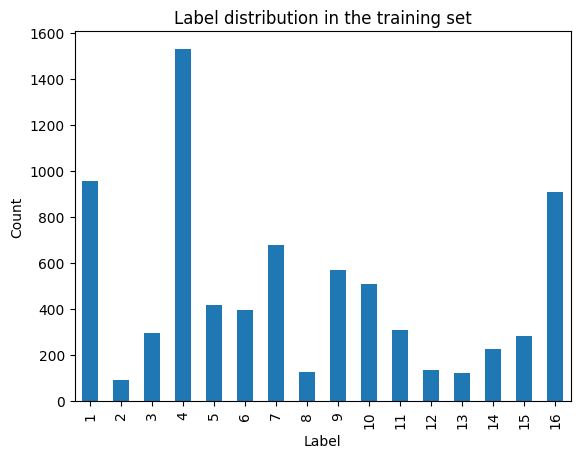

In [37]:
import pandas as pd

# Convert labels to integers and create a DataFrame
df = pd.DataFrame({'Label': [int(x) for x in train_labels]})

# Plot the label distribution in the training set
plt.figure()
df['Label'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Label distribution in the training set')
plt.show()